# Conformalized quantile regression (CQR): Real data experiment

In this tutorial we will load a real dataset and construct prediction intervals using CQR [1].

[1] Yaniv Romano, Evan Patterson, and Emmanuel J. Candes, “Conformalized quantile regression.” 2019.

## Prediction intervals

Suppose we are given $ n $ training samples $ \{(X_i, Y_i)\}_{i=1}^n$ and we must now predict the unknown value of $Y_{n+1}$ at a test point $X_{n+1}$. We assume that all the samples $ \{(X_i,Y_i)\}_{i=1}^{n+1} $ are drawn exchangeably$-$for instance, they may be drawn i.i.d.$-$from an arbitrary joint distribution $P_{XY}$ over the feature vectors $ X\in \mathbb{R}^p $ and response variables $ Y\in \mathbb{R} $. We aim to construct a marginal distribution-free prediction interval $C(X_{n+1}) \subseteq \mathbb{R}$ that is likely to contain the unknown response $Y_{n+1} $. That is, given a desired miscoverage rate $ \alpha $, we ask that
$$ \mathbb{P}\{Y_{n+1} \in C(X_{n+1})\} \geq 1-\alpha $$
for any joint distribution $ P_{XY} $ and any sample size $n$. The probability in this statement is marginal, being taken over all the samples $ \{(X_i, Y_i)\}_{i=1}^{n+1} $.

To accomplish this, we build on the method of split conformal prediction. We first split the training data into two disjoint subsets, a proper training set and a calibration set. We fit two quantile regressors on the proper training set to obtain initial estimates of the lower and upper bounds of the prediction interval. Then, using the calibration set, we conformalize and, if necessary, correct this prediction interval. Unlike the original interval, the conformalized prediction interval is guaranteed to satisfy the coverage requirement regardless of the choice or accuracy of the quantile regression estimator.



## A case study

We start by importing several libraries, loading the real dataset and standardize its features and response. We set the target miscoverage rate $\alpha$ to 0.1.

In [1]:
import torch
import random
import numpy as np
np.warnings.filterwarnings('ignore')

from datasets import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

seed = 1

random_state_train_test = seed
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)
    
# desired miscoverage error
alpha = 0.1

# desired quanitile levels
quantiles = [0.05, 0.95]

# used to determine the size of test set
test_ratio = 0.2

# name of dataset
dataset_base_path = "./datasets/"
dataset_name = "community"

# load the dataset
X, y = datasets.GetDataset(dataset_name, dataset_base_path)

# divide the dataset into test and train based on the test_ratio parameter
x_train, x_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=test_ratio,
                                                    random_state=random_state_train_test)

# reshape the data
x_train = np.asarray(x_train)
y_train = np.asarray(y_train)
x_test = np.asarray(x_test)
y_test = np.asarray(y_test)

# compute input dimensions
n_train = x_train.shape[0]
in_shape = x_train.shape[1]

# display basic information
print("Dataset: %s" % (dataset_name))
print("Dimensions: train set (n=%d, p=%d) ; test set (n=%d, p=%d)" % 
      (x_train.shape[0], x_train.shape[1], x_test.shape[0], x_test.shape[1]))

Dataset: community
Dimensions: train set (n=1595, p=100) ; test set (n=399, p=100)


/Users/kelseydoerksen/opt/anaconda3/envs/sudsaq/lib/python3.7/site-packages/sklearn/utils/deprecation.py:66: DeprecationWarning: Class Imputer is deprecated; Imputer was deprecated in version 0.20 and will be removed in 0.22. Import impute.SimpleImputer from sklearn instead.
  warnings.warn(msg, category=DeprecationWarning)


## Data splitting

We begin by splitting the data into a proper training set and a calibration set. Recall that the main idea is to fit a regression model on the proper training samples, then use the residuals on a held-out validation set to quantify the uncertainty in future predictions.

In [2]:
# divide the data into proper training set and calibration set
idx = np.random.permutation(n_train)
n_half = int(np.floor(n_train/2))
idx_train, idx_cal = idx[:n_half], idx[n_half:2*n_half]

# zero mean and unit variance scaling 
scalerX = StandardScaler()
scalerX = scalerX.fit(x_train[idx_train])

# scale
x_train = scalerX.transform(x_train)
x_test = scalerX.transform(x_test)

# scale the labels by dividing each by the mean absolute response
mean_y_train = np.mean(np.abs(y_train[idx_train]))
y_train = np.squeeze(y_train)/mean_y_train
y_test = np.squeeze(y_test)/mean_y_train

## CQR random forests

Given these two subsets, we now turn to conformalize the initial prediction interval constructed by quantile random forests [2]. Below, we set the hyper-parameters of the CQR random forests method.

[2] Meinshausen Nicolai. "Quantile regression forests." Journal of Machine Learning Research 7, no. Jun (2006): 983-999.

In [6]:
#########################################################
# Quantile random forests parameters
# (See QuantileForestRegressorAdapter class in helper.py)
#########################################################

# the number of trees in the forest
n_estimators = 1000

# the minimum number of samples required to be at a leaf node
# (default skgarden's parameter)
min_samples_leaf = 1

# the number of features to consider when looking for the best split
# (default skgarden's parameter)
max_features = x_train.shape[1]

# target quantile levels
quantiles_forest = [quantiles[0]*100, quantiles[1]*100]

# use cross-validation to tune the quantile levels?
cv_qforest = True

# when tuning the two QRF quantile levels one may
# ask for a prediction band with smaller average coverage
# to avoid too conservative estimation of the prediction band
# This would be equal to coverage_factor*(quantiles[1] - quantiles[0])
coverage_factor = 0.85

# ratio of held-out data, used in cross-validation
cv_test_ratio = 0.05

# seed for splitting the data in cross-validation.
# Also used as the seed in quantile random forests function
cv_random_state = 1

# determines the lowest and highest quantile level parameters.
# This is used when tuning the quanitle levels by cross-validation.
# The smallest value is equal to quantiles[0] - range_vals.
# Similarly, the largest value is equal to quantiles[1] + range_vals.
cv_range_vals = 30

# sweep over a grid of length num_vals when tuning QRF's quantile parameters                   
cv_num_vals = 10

### Symmetric nonconformity score 

In the following cell we run the entire CQR procudure. The class `QuantileForestRegressorAdapter` defines the underlying estimator. The class `RegressorNc` defines the CQR objecct, which uses `QuantileRegErrFunc` as the nonconformity score. The function `run_icp` fits the regression function to the proper training set, corrects (if required) the initial estimate of the prediction interval using the calibration set, and returns the conformal band. Lastly, we compute the average coverage and length on future test data using `compute_coverage`.

In [5]:
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.nc import QuantileRegErrFunc

# define the QRF's parameters 
params_qforest = dict()
params_qforest["n_estimators"] = n_estimators
params_qforest["min_samples_leaf"] = min_samples_leaf
params_qforest["max_features"] = max_features
params_qforest["CV"] = cv_qforest
params_qforest["coverage_factor"] = coverage_factor
params_qforest["test_ratio"] = cv_test_ratio
params_qforest["random_state"] = cv_random_state
params_qforest["range_vals"] = cv_range_vals
params_qforest["num_vals"] = cv_num_vals

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Random Forests")

CQR Random Forests: Percentage in the range (expecting 90.00): 91.228070
CQR Random Forests: Average length: 1.355441


As can be seen, we obtained valid coverage.

### Asymmetric nonconformity score 

The nonconformity score function `QuantileRegErrFunc` treats the left and right tails symmetrically, but if the error distribution is significantly skewed, one may choose to treat them asymmetrically. This can be done by replacing `QuantileRegErrFunc` with `QuantileRegAsymmetricErrFunc`, as implemented in the following cell.

In [6]:
from nonconformist.nc import QuantileRegAsymmetricErrFunc

# define QRF model
quantile_estimator = helper.QuantileForestRegressorAdapter(model=None,
                                                           fit_params=None,
                                                           quantiles=quantiles_forest,
                                                           params=params_qforest)
        
# define the CQR object
nc = RegressorNc(quantile_estimator, QuantileRegAsymmetricErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qforest, length_cp_qforest = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "Asymmetric CQR Random Forests")

Asymmetric CQR Random Forests: Percentage in the range (expecting 90.00): 90.726817
Asymmetric CQR Random Forests: Average length: 1.480756


Above, we also obtained valid coverage.


## CQR neural net

In what follows we will use neural network as the underlying quantile regression method. Below, we set the hyper-parameters of the CQR neural network method.

In [7]:
#####################################################
# Neural network parameters
# (See AllQNet_RegressorAdapter class in helper.py)
#####################################################

# pytorch's optimizer object
nn_learn_func = torch.optim.Adam

# number of epochs
epochs = 1000

# learning rate
lr = 0.0005

# mini-batch size
batch_size = 64

# hidden dimension of the network
hidden_size = 64

# dropout regularization rate
dropout = 0.1

# weight decay regularization
wd = 1e-6

# Ask for a reduced coverage when tuning the network parameters by 
# cross-validataion to avoid too concervative initial estimation of the 
# prediction interval. This estimation will be conformalized by CQR.
quantiles_net = [0.1, 0.9]

We now turn to invoke the CQR procedure. The class `AllQNet_RegressorAdapter` defines the underlying neural network estimator. Just as before, `RegressorNc` defines the CQR objecct, which uses `QuantileRegErrFunc` as the nonconformity score. The function `run_icp` returns the conformal band, computed on test data. Lastly, we compute the average coverage and length using `compute_coverage`.

In [8]:
# define quantile neural network model
from cqr import helper
from nonconformist.nc import RegressorNc
from nonconformist.nc import QuantileRegErrFunc

quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=False)

# define a CQR object, computes the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_qnet, length_cp_qnet = helper.compute_coverage(y_test,
                                                           y_lower,
                                                           y_upper,
                                                           alpha,
                                                           "CQR Neural Net")

CQR Neural Net: Percentage in the range (expecting 90.00): 90.225564
CQR Neural Net: Average length: 1.554184


In [13]:
# Running through run_icp
import sys
import torch
import numpy as np
from cqr import torch_models
from functools import partial
from cqr import tune_params_cv
from nonconformist.cp import IcpRegressor
from nonconformist.base import RegressorAdapter

icp = IcpRegressor(nc,condition=None)

In [20]:
nc

RegressorNc(beta=1e-06,
            err_func=<nonconformist.nc.QuantileRegErrFunc object at 0x7f85cb0c6c10>,
            model=AllQNet_RegressorAdapter(batch_size=64, dropout=0.1,
                                           epochs=1000, fit_params={},
                                           hidden_size=None, in_shape=None,
                                           learn_func=None, lr=0.0005,
                                           model=all_q_model(
  (base_model): Sequential(
    (0): Linear(in_features=100, out_features=64, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.1, inplace=False)
    (3): Linear(in_features=64, out_features=64, bias=True)
    (4): ReLU()
    (5): Dropout(p=0.1, inplace=False)
    (6): Linear(in_features=64, out_features=2, bias=True)
  )
),
                                           quantiles=[0.1, 0.9], random_state=1,
                                           test_ratio=0.05,
                                           use_rearrangement=None, wd=1e-0

In [14]:
icp

IcpRegressor(condition=<function BaseIcp.__init__.<locals>.<lambda> at 0x7f85cba477a0>,
             nc_function=RegressorNc(beta=1e-06,
                                     err_func=<nonconformist.nc.QuantileRegErrFunc object at 0x7f85cb0c6c10>,
                                     model=AllQNet_RegressorAdapter(batch_size=64,
                                                                    dropout=0.1,
                                                                    epochs=1000,
                                                                    fit_params={},
                                                                    hidden_size=None,
                                                                    in_shape=None,
                                                                    learn_func=None,
                                                                    lr=0.0005,
                                                                    model=all_q_model(
  (ba

In [17]:
icp.fit(x_train[idx_train,:], y_train[idx_train])

In [19]:
icp.calibrate(x_train[idx_cal,:], y_train[idx_cal])

In [21]:
predictions = icp.predict(x_test, significance=alpha)

In [22]:
predictions

array([[ 7.19494969e-02,  4.18784082e-01],
       [ 3.80520880e-01,  1.79201162e+00],
       [ 3.94972980e-01,  1.41380620e+00],
       [ 6.36266917e-02,  4.46249127e-01],
       [ 4.67539191e-01,  1.18257296e+00],
       [ 1.21221766e-01,  8.43463659e-01],
       [ 4.29631352e-01,  1.56818366e+00],
       [ 8.84839445e-02,  5.83734334e-01],
       [ 8.69185328e-01,  2.55531049e+00],
       [ 5.93769670e-01,  2.43606210e+00],
       [ 1.14286935e+00,  2.66726017e+00],
       [ 1.02682188e-02,  3.42255354e-01],
       [ 3.45561147e-01,  1.64751816e+00],
       [ 5.22983432e-01,  1.45912004e+00],
       [ 1.11952841e-01,  5.45907080e-01],
       [ 1.66081920e-01,  8.14099550e-01],
       [ 1.65789649e-01,  1.24897826e+00],
       [ 7.65161157e-01,  2.24853253e+00],
       [ 6.05506599e-02,  4.22009706e-01],
       [ 5.54157197e-01,  2.37352014e+00],
       [ 7.23436847e-03,  3.26442361e-01],
       [ 2.32200876e-01,  1.18970656e+00],
       [ 4.69162464e-02,  5.57735503e-01],
       [-3.

In [23]:
y_lower = predictions[:,0]

In [24]:
y_upper = y_lower = predictions[:,1]

In [25]:
y_test

array([0.25062895, 1.5455452 , 0.91897285, 0.04177149, 0.66834384,
       0.33417192, 0.41771492, 0.41771492, 1.1696018 , 1.1696018 ,
       1.9214886 , 0.12531447, 0.37594345, 0.91897285, 0.20885746,
       0.7518869 , 0.08354298, 1.1696018 , 0.08354298, 1.6708597 ,
       0.08354298, 1.4202307 , 0.25062895, 0.29240045, 0.91897285,
       0.45948642, 1.4202307 , 2.882233  , 0.08354298, 2.7569187 ,
       0.41771492, 0.8772013 , 0.08354298, 1.2949163 , 0.37594345,
       2.0468032 , 0.7101154 , 0.7936583 , 2.4645178 , 1.1278304 ,
       1.0860587 , 0.        , 0.29240045, 1.2531449 , 1.0442873 ,
       0.91897285, 0.5848009 , 2.6733754 , 0.16708596, 2.0050316 ,
       2.7569187 , 1.1278304 , 2.882233  , 0.25062895, 0.5848009 ,
       0.45948642, 0.5848009 , 0.83542985, 0.04177149, 0.5012579 ,
       1.5873166 , 0.66834384, 0.12531447, 1.3784593 , 0.62657243,
       0.54302937, 0.41771492, 2.0885746 , 0.5848009 , 0.5848009 ,
       0.20885746, 0.20885746, 0.5848009 , 1.4620022 , 0.37594

In [ ]:
pip install matplotlib

In [30]:
import matplotlib.pyplot as plt

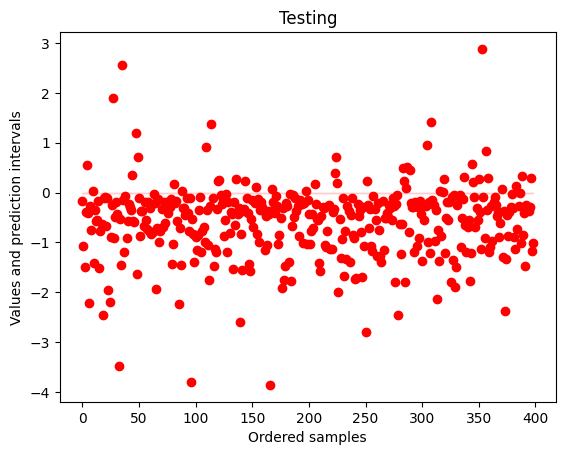

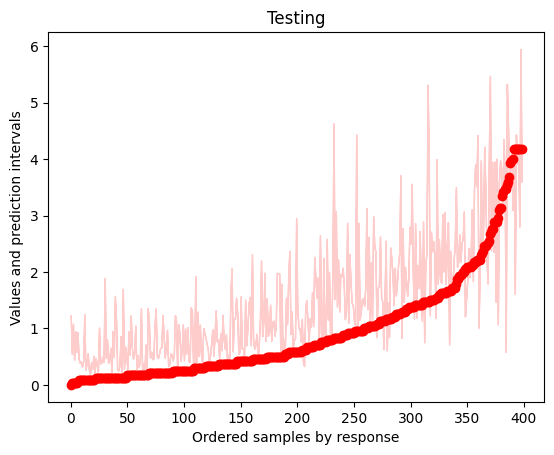

In [28]:
helper.plot_func_data(y_test, y_lower, y_upper, name='Testing')

Above, we can see that the prediction interval constructed by CQR Neural Net is also valid. Notice the difference in the average length between the two methods (CQR Neural Net and CQR Random Forests). 

## CQR neural net with rearrangement

Crossing quantiles is a longstanding problem in quantile regression. This issue does not affect the validity guarantee of CQR as it holds regardless of the accuracy or choice of the quantile regression method. However, this may affect the effeciency of the resulting conformal band.

Below we use the rearrangement method [3] to bypass the crossing quantile problem. Notice that we pass `use_rearrangement=True` as an argument to `AllQNet_RegressorAdapter`.

[3] Chernozhukov Victor, Iván Fernández‐Val, and Alfred Galichon. “Quantile and probability curves without crossing.” Econometrica 78, no. 3 (2010): 1093-1125.

In [9]:
# define quantile neural network model, using the rearrangement algorithm
quantile_estimator = helper.AllQNet_RegressorAdapter(model=None,
                                                     fit_params=None,
                                                     in_shape=in_shape,
                                                     hidden_size=hidden_size,
                                                     quantiles=quantiles_net,
                                                     learn_func=nn_learn_func,
                                                     epochs=epochs,
                                                     batch_size=batch_size,
                                                     dropout=dropout,
                                                     lr=lr,
                                                     wd=wd,
                                                     test_ratio=cv_test_ratio,
                                                     random_state=cv_random_state,
                                                     use_rearrangement=True)

# define the CQR object, computing the absolute residual error of points 
# located outside the estimated quantile neural network band 
nc = RegressorNc(quantile_estimator, QuantileRegErrFunc())

# run CQR procedure
y_lower, y_upper = helper.run_icp(nc, x_train, y_train, x_test, idx_train, idx_cal, alpha)

# compute and print average coverage and average length
coverage_cp_re_qnet, length_cp_re_qnet = helper.compute_coverage(y_test,
                                                                 y_lower,
                                                                 y_upper,
                                                                 alpha,
                                                                 "CQR Rearrangement Neural Net")

CQR Rearrangement Neural Net: Percentage in the range (expecting 90.00): 89.974937
CQR Rearrangement Neural Net: Average length: 1.476710
